# QOSF Screening Task # 2
<p><a href="#Complete-Code">CLICK HERE</a> (or scroll down) to skip to the complete code and corresponding visualizations if you don't want to go through the details of each part of the code :) .</p>

In [6]:
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_state_qsphere
import random
backend = Aer.get_backend('qasm_simulator')

<p>First, we initialise a 2 qubit register (qr), 2 classical bit register (ar) and 4 ancillary qubit register (a). The ancillary qubits are needed (2 each) for the type of noise that we will introduce later. We do this via the following code:</p>

In [7]:
qr = QuantumRegister(2,'q')
a = QuantumRegister(4,'a')
cr= ClassicalRegister(2,'c')

<p>Now, we construct our quantum circuit as prescribed in the task, i.e apply the hadamard gate to the 1st qubit. We add a barrier after this so that we can iso late the noise in the later diagrams:</p>

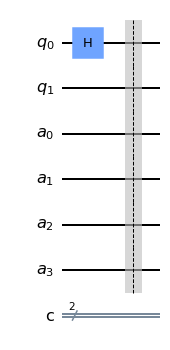

In [8]:
circuit = QuantumCircuit(qr,a,cr)
circuit.h(0)
circuit.barrier()
#NOISE
circuit.draw("mpl")

# Adding Noise
<p>Now, we introduce the bit-flip and phase-flip noise to both qubits (qr) before the CNOT is applied, i.e after the 1st barrier in the circuit above.

As per the given requirements in the task and given that Z = phase flip error and X = bit flip error, the possible noise combinations will be XZ|+0>, XX|+0>, XI|+0>, ZZ|+0>, ZX|+0>, ZI|+0>, IZ|+0>, IX|+0>. 

Since the noise is after the Hadaard gate and as bitflip is just phase flip in hadamard basis, this helps us remove some possibilities since bit-flip will have no overall affect on q0 and will only get affected by the phase-flip. Similarly, for q1 we will be concerned only with the bit-flip and can ignore the phase flip. This simplifies our possible combinations and we then only cater for the following: ZX|+0>, ZI|+0> and IX|+0>

That being said, we still need to assign random (non zero) probabilities for both types of errors corresponding to their repective qubits (q0, q1). We achieve this by creating a random number (r) that takes a value from 1 of 3 intervals where each interval corresponds to a specific combination, e.g: say the random number is between 1 and 30 hence we can make 3 possible intervals for each combination as: <br />
    1. 01-10 ->The noise is: ZX
    2. 11-20 ->The noise is: ZI
    3. 21-30 ->The noise is: IX
In this example since the ength of the intervals is equal, each combination has the probability 1/3. However, we can always change the intervals and therefore change the probability.
    
We then introduce the random noise cases in our circuit via the following code:
</p>

The noise is: ZI


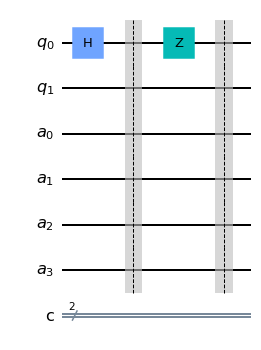

In [9]:
r = random.randint(1,30) # for the cases ZX, ZI and IX
if r<=20:
    print('The noise is: ZX') 
    circuit.z(0)
    circuit.x(1)
elif r<=25 and r>20:
    print('The noise is: ZI')
    circuit.z(0)
elif r<=30 and r>25:
    print('The noise is: IX')
    circuit.x(1)
circuit.barrier()
circuit.draw("mpl")
#!!! NOTE: The pring statement only tells us what noise is and doesnt affect the circuit in any way !!!

<p>Now that our circuit adds the error with a certain probability to either of the two qubits, we can move on towards error correction. Rather than use the Shors code we take care of each error seperately. For this we will need 2+2 ancialliary qubits overall. (2:Bflip , 2:Pflip)</p>

# Negating phase flip error
<p>This part converts the state of the concerned qubit, q0, from state |-> to state |+> assuming Phase flip error ha soccured and does nothing otherwise.

In essense, the the bit-flip error in hadamard basis is the phase flip error and is equivalent to a Z-gate. It can corrected using the phase flip code. Now the phase flip code is quite similar to the bit flip code that we will use later. Hence, we take care of this error in the following steps:
    1. Apply the hadamard gate to the concerned qubit, q1.
    2. Taking q0 as the control bit, apply CNOT gates to transfer the computational state of the qubit (q0) to the other ancillary qubits (a0,a1).
    3. By using a toffoli gate now with qubit q1 as the target, and the ancillary qubits (a0,a1) as the control, we flip the computational state of qubit q0.
    4. Finally, we apply the Hadamard gate again.
    
Whats happening here is quite simple to understand. In the first step we take the qubit from hadamard to computation basis. For the rest of the three setps let us give an example. 

Say the computational state of q0, after the hadamard in the first step, is |0> (essentially meaning phase flip doesnt occur). CNOT gates will be applied to the ancillary qubits (a2,a3) but will leave them unchanged because the control qubit, q0, was |0>. Simillarly, the toffoli gate then would have no effect on q0 either. So the final hadamard gate will once again give us the state |+>.
    
Now, Assuming phase flip has occured q0 would then be in computational state |1> ater the hadamard gate is applied in step 1. The CNOT gates then applied to the ancillary qubits (a0,a1) will flip their states to |1> since now the control qubit, q0, has the state |1>. When that is the case, the toffoli gate with target qubit, q0, will flip its state back to |0>. The final hadamard gate will once again give us the state |+> and hence removing the error.

We implement this via the following code:
</p>

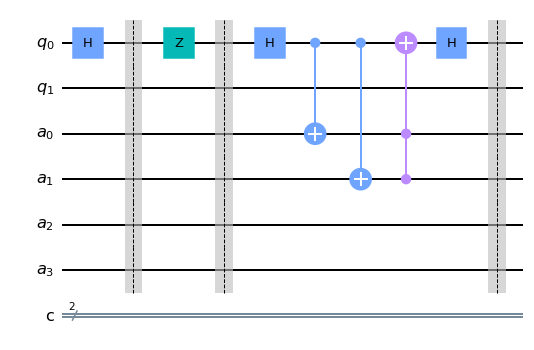

In [10]:
#To remove the phase-flip correction we just comment out this entore cell of code
circuit.h(0)
circuit.cx(qr[0],a[0])
circuit.cx(qr[0],a[1])
circuit.ccx(a[1],a[0],qr[0])
circuit.h(0)
circuit.barrier()
circuit.draw("mpl")

# Negating bit flip error
<p>We know that because of the bit flip error the qubits computational state changes/flips from 0 to 1 or vice versa. For our purpoes, since the qubits is initialized in the computationa state |0>, Bit flip error would mean the qubit, q1, flips to 1. Hence we need to flip the qubits state from |1> state to |0> and do nothing if the initial state is |0>. For this we use our Bit-flip code.

<b>Bit Flip Code</b>
This essentially is a 3 qubit circuit that uses of 2 ancillary qubits to fix the error in 1 qubit. We achieve this via the following steps: <br />
    1. With q1 as the control bit, apply CNOT gates to transfer the computational state of the qubit (q1) to the other ancillary qubits (a2,a3). 
    2. A toffoli gate is applied to the first qubit which will correct its state.

For example, let’s say the state of q1 was |0>. CNOT gates will be applied to the ancillary qubits (a2,a3) but will leave them unchanged because the control bit, q1, was |0>. 
    
Assuming bit flip has occured and q1 is now in state |1>, then the CNOT gates applied to the ancillary qubits (a2,a3) will flip their states to |1> since now the control bit, q1, has the state |1>. When that is the case, the toffoli gate applied to the main qubit, q1, will flip its state back to |0>, since the ancillary qubits (a2,a3) are in state |1>, and this corrects the error. 

We implement this via the following code:
</p>

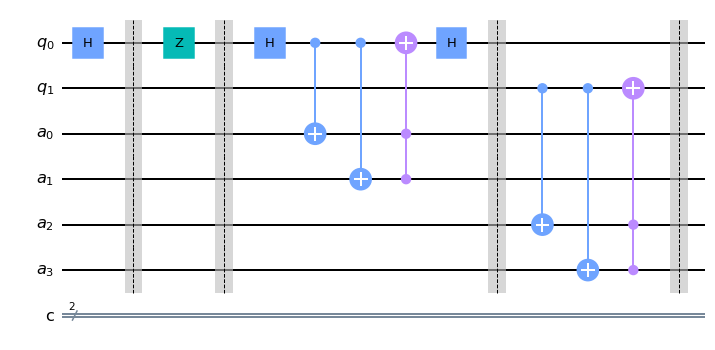

In [11]:
#To remove the bit-flip correction we just comment out this entore cell of code
circuit.cx(qr[1],a[2])
circuit.cx(qr[1],a[3])
circuit.ccx(a[3],a[2],qr[1])
circuit.barrier()
circuit.draw("mpl")

<p>To complete our circuit we can now apply the final CNOT gate via the following code:</p>

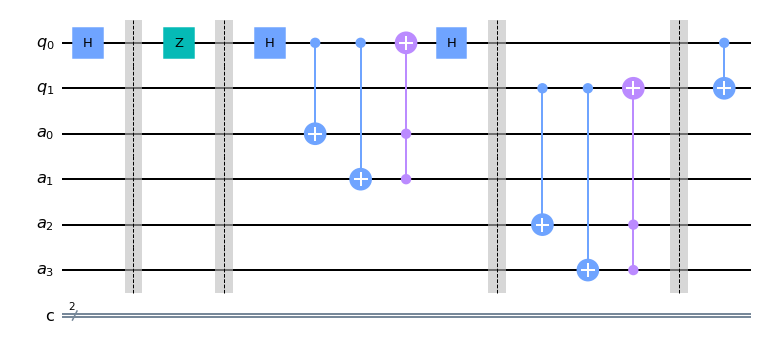

In [12]:
circuit.cx(0,1)
circuit.draw("mpl")

# Visualization (q-sphere)
<p>It is easy to verify the final state of the system via visualizing the result traced over anciliary qubits on the q-sphere</p>

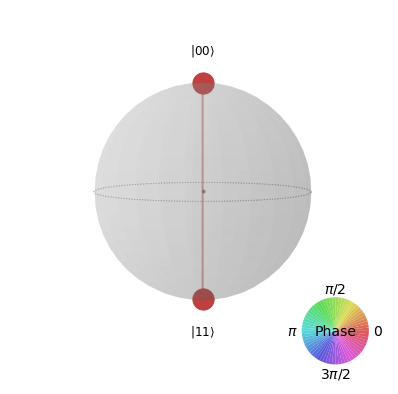

In [13]:
state = Statevector.from_instruction(circuit)
rstate = partial_trace(state, [2,3,4,5])
plot_state_qsphere(rstate)

# Histogram for multiple counts
<p>We can also see the output as a histogram by running our circuit for multiple shots</p>

In [14]:
circuit.measure(qr,cr)
job = execute(circuit, backend, shots=1024)
job_monitor(job)
counts = execute(circuit,backend).result().get_counts()

Job Status: job has successfully run


In [15]:
print(counts)

{'00': 517, '11': 507}


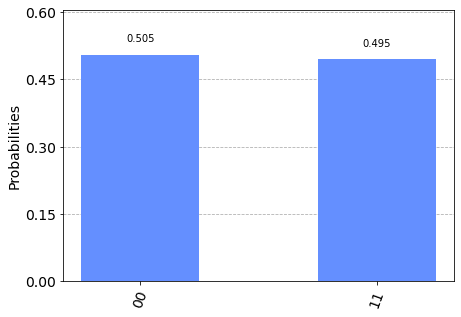

In [16]:
plot_histogram(counts)

# Type of Noise
<p> What if we want to know whether or not an error was fixed while runing our circuit? and if yes, then which one? 
As it turns our, our ancillary qubits we can successfully answer these questions. 

After we run our circuit, the ancillary qubits can have 1 of four poissible resulting states. We can tell the type of the error by measuring or visualizing these ancillary states, i.e |a3 a2 a1 a0>. The possible states are:<br />
    1. |0000> = No noise in the system
    2. |0011> = ZI
    3. |1100> = IX
    4. |1111> = ZX
</p>

This is because of using CNOT gates while error correcting for both phase flip and bit flip errors.
Again, we can measure the qubits for multiple shots alonside the measurement of the main qubits q0 and q1. Here, however, below is a qsphere representation of the ancillary qubit states.

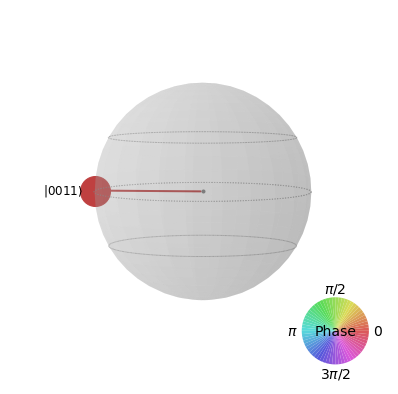

In [53]:
anstate = partial_trace(state,[0,1])
plot_state_qsphere(anstate) # Plot q-sphere for ancilary states

# Complete Code

In [54]:
# Lets import the necessary things to get started
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram # visualization
from qiskit.quantum_info import Statevector, partial_trace # needed for partial trace and q-sphere
from qiskit.visualization import plot_state_qsphere # visualization
import random
backend = Aer.get_backend('qasm_simulator')
#--------------------------------------------------------

# Defining the circuit and ancilla
qr = QuantumRegister(2,'q') # quantum registers
a = QuantumRegister(4,'a') # ancilllary qbits
cr= ClassicalRegister(2,'c') # classical bits
circuit = QuantumCircuit(qr,a,cr)
circuit.h(0)
#--------------------------------------------------------

#introducing noise
r = random.randint(1,30) # for the cases ZX, ZI and IX
if r<=10:
    print('The noise is: ZX')
    circuit.z(0)
    circuit.x(1)
elif r<=20 and r>10:
    print('The noise is: ZI')
    circuit.z(0)
elif r<=30 and r>20:
    print('The noise is: IX')
    circuit.x(1)
#--------------------------------------------------------
#!!!--- To remove the correction we just comment out this entore block of code--- !!!
# # Negating phase flip error
circuit.h(0)
circuit.cx(qr[0],a[0])
circuit.cx(qr[0],a[1])
circuit.ccx(a[1],a[0],qr[0])
circuit.h(0)
# # Negating bit flip error
circuit.cx(qr[1],a[2])
circuit.cx(qr[1],a[3])
circuit.ccx(a[3],a[2],qr[1])
#--------------------------------------------------------

#Applying CNOT
circuit.cx(0,1)
#--------------------------------------------------------

#Visualizing the result

#as q-sphere
state = Statevector.from_instruction(circuit)
rstate = partial_trace(state, [2,3,4,5])
anstate = partial_trace(state,[0,1]) # to tell type of noise that was fixed
# get counts
circuit.measure(qr,cr)
job = execute(circuit, backend, shots=1000)
job_monitor(job)
counts = execute(circuit,backend).result().get_counts()

The noise is: ZX
Job Status: job has successfully run


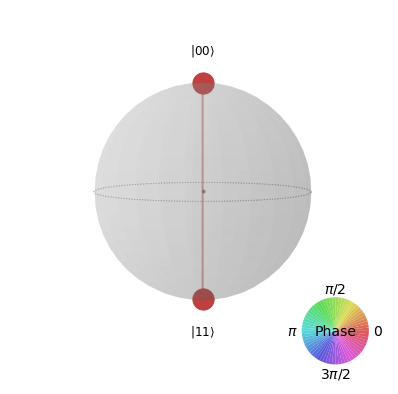

In [55]:
plot_state_qsphere(rstate) # Plot q-sphere

In [56]:
print(counts) # Get counts

{'00': 496, '11': 528}


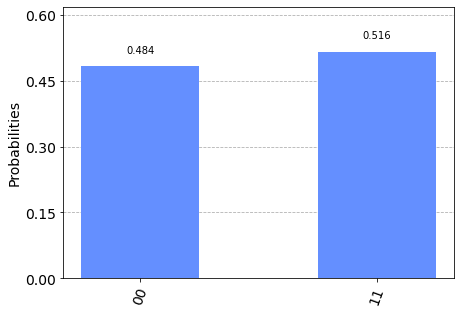

In [57]:
plot_histogram(counts) # Plot histogram

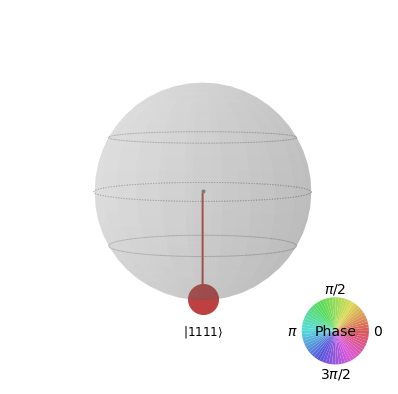

In [58]:
plot_state_qsphere(anstate) # Plot q-sphere for ancilary states to tell the type of error